In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import datasets, transforms

In [2]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

### 1. Configurare

In [3]:
BATCH_SIZE = 64
LR = 0.001
EPOCHS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 2. Descărcăm și pregătim datele

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Mean and Std of MNIST
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.02MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 128kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.4MB/s]


### 3. Definim arhitectura rețelei neuronale

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Conv Block 1: Input 1x28x28 -> Output 32x26x26
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
        self.relu = nn.ReLU()
        # Max Pool: Output 32x13x13
        self.pool = nn.MaxPool2d(kernel_size=2)

        # Conv Block 2: Input 32x13x13 -> Output 64x11x11
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        # Max Pool: Output 64x5x5

        # Fully Connected Layers
        # 64 channels x 5 x 5 image size
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 Digits

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Layer 2
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        # Flatten
        x = torch.flatten(x, 1)

        # Dense Layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

### 4. Inițializăm CNN-ul și funcțiile ajutătoare

In [6]:
model = SimpleCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

Verificăm arhitectura modelului, afișând rezumatul

In [7]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
         MaxPool2d-3           [-1, 32, 13, 13]               0
            Conv2d-4           [-1, 64, 11, 11]          18,496
              ReLU-5           [-1, 64, 11, 11]               0
         MaxPool2d-6             [-1, 64, 5, 5]               0
            Linear-7                  [-1, 128]         204,928
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 225,034
Trainable params: 225,034
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.50
Params size (MB): 0.86
Estimated Total Size (MB): 1.37
-------------------------------------------

### 5. Antrenăm CNN-ul și urmărim evoluția

In [8]:
loss_history = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {avg_loss:.4f}")

Epoch 1/5, Loss: 0.1343
Epoch 2/5, Loss: 0.0418
Epoch 3/5, Loss: 0.0278
Epoch 4/5, Loss: 0.0217
Epoch 5/5, Loss: 0.0154


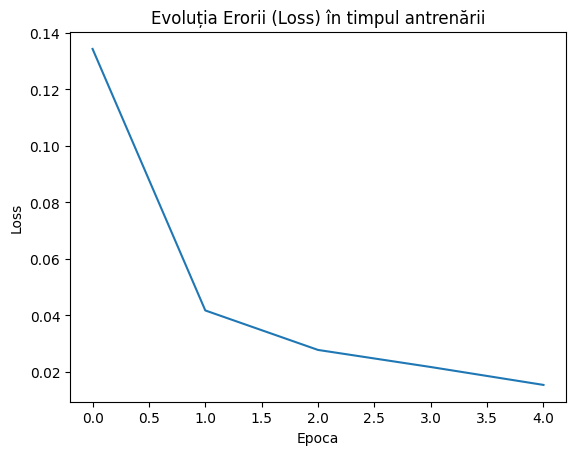

In [9]:
plt.plot(loss_history)
plt.title("Evoluția Erorii (Loss) în timpul antrenării")
plt.xlabel("Epoca")
plt.ylabel("Loss")
plt.show()

### 6. Validăm modelul antrenat

In [10]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test images: {100 * correct / total:.2f}%')

Accuracy of the network on test images: 99.15%


### 7. Matrice de Confuzie și Exemple Greșite

In [11]:
def get_all_preds(model, loader):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            preds = model(images)
            all_preds.extend(preds.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.numpy())
    return np.array(all_preds), np.array(all_labels)

In [12]:
test_preds, test_labels = get_all_preds(model, test_loader)

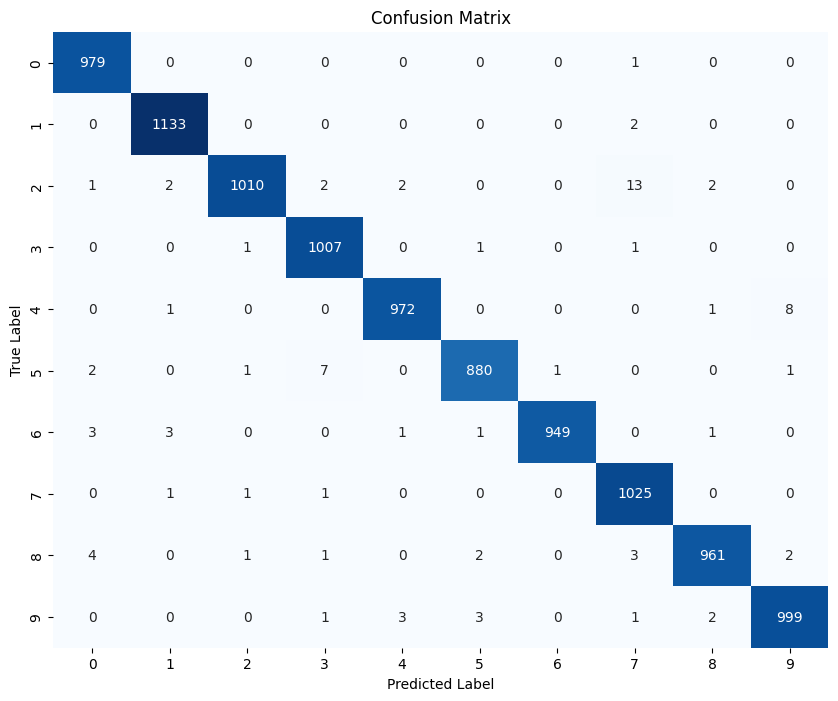

In [13]:
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Afișare exemple clasificate greșit

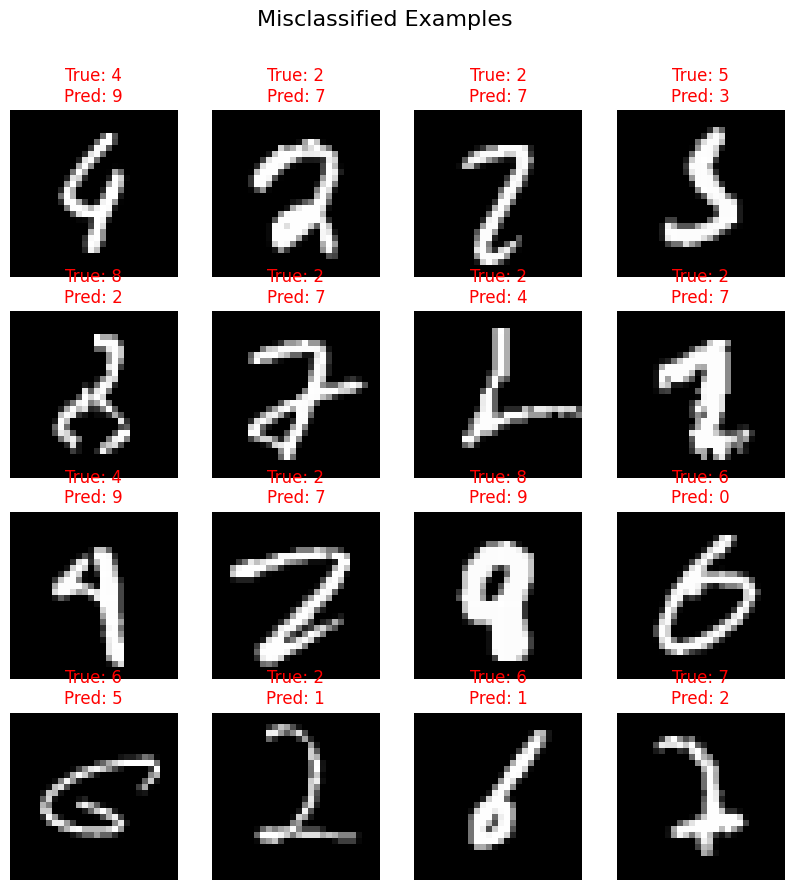

In [14]:
misclassified_idxs = np.where(test_preds != test_labels)[0]
figure = plt.figure(figsize=(10, 10))
rows, cols = 4, 4

for i in range(min(16, len(misclassified_idxs))):
    idx = misclassified_idxs[i]
    img, label = test_dataset[idx]  # Get original image
    pred_label = test_preds[idx]

    figure.add_subplot(rows, cols, i + 1)

    # Un-normalize for display: img * std + mean
    # (0.3081, 0.1307) are the transform values
    img_display = img * 0.3081 + 0.1307
    plt.imshow(img_display.squeeze(), cmap="gray")
    plt.title(f"True: {label}\nPred: {pred_label}", color="red")
    plt.axis("off")

plt.suptitle("Misclassified Examples", fontsize=16)
plt.show()